# Beer Analysis

For this project I scraped the ratings of 458,978 beers from a popular beer rating website. I will conduct some analysis on the beers and their ratings and try to develop a model to predict the rating of a beer based on some of its features.

In [262]:
# Python Standard Library
import json
import random

# Python 3rd-Party Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble \
    import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import tree

## Helper Functions

The following functions will be useful for analysis and preprocessing of the data.

In [268]:
# Some functions for analysis and preprocessing
# ------------------------------------------------------------------------------
def encode(df, column):
    """Encodes column in df (replacing w/ encoded) and returns encoder
    
    df: pd.DataFrame
    column: str
    """
    le = LabelEncoder()
    le.fit(df[column])
    df[column] = le.transform(df[column])
    return le

def getMostCommonTags(df, tagscol='tags', n=40):
    """Returns n most common tags as a list
    
    df: pd.DataFrame
    col: str
    n: int
    """
    tagcount = dict()
    for tags in df[tagscol]:
        for tag in tags:
            tagcount[tag] = tagcount.setdefault(tag, 0) + 1
    taglist = list(tagcount.items())
    taglist.sort(key=lambda x: x[1], reverse=True)
    return [tag for tag, _ in taglist[:n]]

def encodeTags(df, tagscol='tags', tags=None):
    """Inserts columns for each tag in tags so that if record has tag 
         entry is 1, else entry is 0 (a binary encoding)
    
    df: pd.DataFrame
    tagscol: str
    tags: list
    """
    tags = tags if tags is not None else []
    kwargs = dict()
    for tag in tags:
        kwargs[tag] = df[tagscol].map(lambda x: int(tag in x))
    return df.assign(**kwargs)

# ------------------------------------------------------------------------------
def split(df, split=[0.6, 0.2, 0.2]):
    """Split data into train, validation, test using percentages in split
    
    df: pd.DataFrame
    split: list
    """
    size = len(df)
    firstsplit = int(split[0]*size)
    if len(split) == 3 or sum(split) != 1:
        secondsplit = int(sum(split[0:2])*size)
        train, valid, test = \
            np.split(df.sample(frac=1), [firstsplit, secondsplit])
        return train, valid, test
    else:
        train, test = np.split(df.sample(frac=1), [firstsplit])
        return train, test


def cost(y, yhat, criteria='mse'):
    """Returns MSE or MAE
    
    y: pd.Series / np.array
    yhat: pd.Series / np.array
    """
    if criteria == 'mse':
        return (1.0/len(y))*np.sum(np.square(y-yhat))
    elif criteria == 'mae':
        return (1.0/len(y))*np.sum(np.abs(y-yhat))


def insertAvgByGroup(df, group, toavg='rating'):
    """Inserts column with average for a specified group
    
    df: pd.DataFrame
    group: str
    toavg: str
    """
    groupMeans = df.groupby(by=[group])[toavg].mean()
    kwargs = {group + 'avg': df[group].map(lambda x: groupMeans[x])}
    return df.assign(**kwargs)


def insertCntByGroup(df, group, tocnt='rating'):
    """Inserts column with counts for a specified group
    
    df: pd.DataFrame
    group: str
    tocnt: str
    """
    groupCnts = df.groupby(by=[group])[tocnt].count()
    kwargs = {group + 'cnt': df[group].map(lambda x: groupCnts[x])}
    return df.assign(**kwargs)


# ------------------------------------------------------------------------------
def getRandomRecords(count, df, column='beer'):
    """Randomly chooses and returns list of records from column of length count
    
    count: int
    df: pd.DataFrame
    column = str
    """
    randm = []
    for i in range(count):
        idx = random.choice(df.index)
        randm.append(df.loc[idx, column])
    return randm


def filterRecords(df, tofilter, filtercol='beers'):
    """Returns DataFrame with filtered records
    
    df: pd.DataFrame
    tofilter: list
    filtercol: str
    """
    copy = df.copy()
    return copy.loc[df[filtercol].map(lambda x: x in tofilter), :]

# ------------------------------------------------------------------------------

def evaluate(y, yhat, model_type):
    yhat_test = model.predict(X_test)
    print('Cost applied to test (using %s): %11.3f' %
          (model_type, cost(y_test, yhat_test)))
    print()
    errors = yhat_test-y_test
    abserrors = np.abs(yhat_test-y_test)
    print('Percentage of absolute errors that are less than 10: %.2f%%' % 
          (len(abserrors[abserrors < 10])*100.0/len(abserrors)))
    print()
    print('Absolute Errors description:\n')
    print(abserrors.describe())
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    errors.hist(bins=25, ax=ax1)
    ax1.set_title('Errors (using %s)' % model_type)
    abserrors.hist(bins=25, ax=ax2)
    ax2.set_title('Absoute Errors (using %s)' % model_type)
    plt.plot()

# This function was used to decode some utf-8 chars in the scraped data.
# The decoded data was exported so that this function is no longer needed.
#
#def encodeStrings(data, keys=None, keysValsAsLists=None):
#    """Encodes/decodes the strings in UTF-8 so that they are printable
#    
#    data: dictionary
#    keys: list
#    keysValsAsLists: list
#    """
#    copy = data.copy()
#    for record in copy:
#        for key, val in record.items():
#            if keys and key in keys:
#                val = val.encode('utf-8')
#                record[key] = val.decode('utf-8')
#            elif keysValsAsLists and key in keysValsAsLists:
#                for idx, tag in enumerate(val):
#                    tag = tag.encode('utf-8')
#                    val[idx] = tag.decode('utf-8')
#    return copy

## The Data

Let's import the data, preprocess it, and have a peek.

In [71]:
# Import and preprocess data for analysis
# ------------------------------------------------------------------------------

# Import step; notice we drop any beers with no rating
with open('beers-decoded.json', 'r') as f:
    data = json.load(f)
beerdf = (pd.DataFrame(data, index=[b['page'] for b in data])  # Idx by page no.
            .dropna(axis=0, subset=['rating'])
            .drop('page', axis=1)  # Page is in index; can drop
         )

# Encoding step (converts categorical to quantitative)
brewery_le = encode(beerdf, 'brewery')
style_le = encode(beerdf, 'style')
taglist = getMostCommonTags(beerdf)
beerdf = encodeTags(beerdf, tags=taglist).drop('tags', axis=1)

# Insert averages/count by brewery/style
beerdf = insertAvgByGroup(beerdf, 'brewery')
beerdf = insertAvgByGroup(beerdf, 'style')
beerdf = insertCntByGroup(beerdf, 'brewery')

# Reorder the columns
cols = (['beer', 'brewery', 'style'] + sorted(taglist) 
        + ['breweryavg', 'brewerycnt', 'styleavg', 'rating'])
beerdf = beerdf.loc[:, cols]

# Split data for train, validation, test
beer_train, beer_valid, beer_test = split(beerdf)

# Peek
beerdf.head()

,beer,brewery,style,#1001 beers you must taste before you die,#amarillo,#anniversary,#barrel aged,#bottle conditioned,#bourbon barrel,#brettanomyces,...,#sugar,#super saison,#tettnang,#vanilla,#whiskey barrel,#wine barrel,breweryavg,brewerycnt,styleavg,rating
1,Beamish Irish Stout,4906,23,0,0,0,1,0,0,0,...,0,0,0,0,0,0,43.000000,4,62.124324,75.0
2,Abita Amber Lager,121,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,28.541593,16.0
3,Abita Andygator,121,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,63.410412,32.0
4,Abita Bock,121,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,45.931904,29.0
5,Abita Christmas Ale,121,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,46.835673,26.0


## Initial Analysis

Let's have a look at some descriptive stats.

In [72]:
# Descriptive statistics
# ------------------------------------------------------------------------------
cols = ['brewery', 'style', taglist[0], taglist[-1], 'breweryavg', 
        'brewerycnt', 'styleavg', 'rating']
beerdf[cols].describe()

,brewery,style,#cascade,#chiles,breweryavg,brewerycnt,styleavg,rating
count,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000
mean,5470.750107,42.021146,0.025878,0.004750,57.609250,53.681055,57.609250,57.609250
std,3159.101833,27.406665,0.158771,0.068754,23.170819,90.139561,20.271675,28.638652
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.015979,0.000000
25%,2644.000000,16.000000,0.000000,0.000000,40.750000,10.000000,41.751687,36.000000
50%,5458.000000,41.000000,0.000000,0.000000,60.428571,25.000000,62.124324,57.000000
75%,8263.000000,61.000000,0.000000,0.000000,77.073171,63.000000,72.694758,85.000000
max,10849.000000,93.000000,1.000000,1.000000,100.000000,764.000000,91.421053,100.000000


After dropping beers with no rating, we're left with 112,220 beers. Not bad. Take one down, pass it around...

Some observations:
* There are 10849 total breweries and 93 total styles (max of each column).
* Each tag seems to range from about 0.48% of beers to 2.59% of beers (seen from mean of \#cascade/\#chiles).
* The total average rating is 57.6, slightly above of the midrange (50).
* Each brewery has on average about 54 beers
* There's a brewery with 764 beers! :)
* There's a brewery with an average rating of 0... :'(

Those last two observations are somewhat interesting. Let's figure out which breweries these are.

In [73]:
# Curious which brewery has 764 beers and which brewery has an average of 0...
# ------------------------------------------------------------------------------
has764 = beerdf.loc[beerdf.brewerycnt == 764.0, 'brewery'].drop_duplicates()
avg0 = (beerdf
        .loc[beerdf.breweryavg == 0.0, ['brewery', 'brewerycnt']]
        .drop_duplicates()
       )
has764str = ', '.join(brewery_le.inverse_transform(has764))
avg0str = '\n'.join(
    [' - ' + brewery_le.inverse_transform(r[0])
     + "... with " + str(r[1]) + " rated beer(s)"
     for r in avg0.as_matrix()])

print('Brewerys with 764 beers: ', has764str)
print()
print('Brewerys with average rating = 0:\n', avg0str)

Brewerys with 764 beers:  Mikkeller

Brewerys with average rating = 0:
  - Black Mountain Brewing Co.... with 1 rated beer(s)
 - Camo Beer Company... with 4 rated beer(s)
 - Jebsen Beer... with 1 rated beer(s)
 - Huanghe Beer Company (Carlsberg)... with 1 rated beer(s)
 - Kgalagadi Breweries (SABMiller)... with 1 rated beer(s)
 - Aujan Industries Co.... with 1 rated beer(s)
 - Arpanoosh / Khorshid Zareewar... with 1 rated beer(s)
 - Mahmood Saeed Beverage Industry... with 1 rated beer(s)
 - Urwibutso Enterprise... with 1 rated beer(s)
 - Siamsato Brewery... with 1 rated beer(s)
 - Iran Bartar Industrial and Agricultural Company... with 1 rated beer(s)
 - Espiritu de Mexico... with 1 rated beer(s)


Let's see how the ratings are distributed.

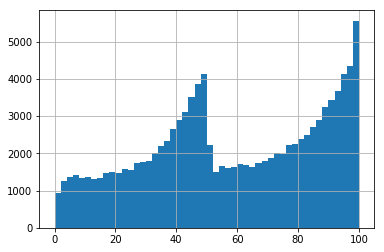

In [232]:
beerdf['rating'].hist(bins=50)

Interesting distribution. The ratings seem to mostly concentrate around 50 and 100.

Let's investigate which breweries and styles are the most popular.

------------------------------------------------------------------------
|Brewery                                                | Rating| Count|
------------------------------------------------------------------------
|Wicked Barrel                                          | 100.00|     1|
|Neill & Ross                                           | 100.00|     1|
|Westvleteren Abdij St. Sixtus                          |  99.50|     4|
|Brasserie Rochefort                                    |  99.33|     3|
|Schramm’s Mead                                         |  99.14|    22|
|Domaine des Côtes d’Ardoise                            |  99.00|     1|
|Takasago Shuzo Sake Co.                                |  99.00|     1|
|Entre Pierre et Terre                                  |  99.00|     1|
|Boombox                                                |  99.00|     1|
|Clos Saint-Denis                                       |  99.00|     2|
|Backacre Beermakers                               

(95, 102)

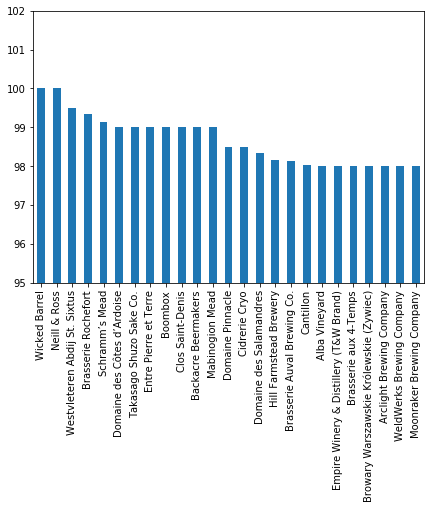

In [257]:
# Get the n most highly rated breweries
# ------------------------------------------------------------------------------
n = 25
byBrewery = beerdf.groupby(['brewery'])
brewerymeans = byBrewery.rating.mean().sort_values(ascending=False)
brewerycounts = [byBrewery.get_group(brewery)['beer'].count()
                 for brewery in brewerymeans.index]
brewerymeans.index = brewery_le.inverse_transform(brewerymeans.index)  # Decode

# Prints table of n most highly rated breweries with avg rating and beer count
print('-'*72)
print('|%-55s|%7s|%6s|' % ('Brewery', 'Rating', 'Count'))
print('-'*72)
for b, r, c in zip(brewerymeans[:n].index, brewerymeans[:n], brewerycounts[:n]):
    print('|%-55s|%7.2f|%6d|' % (b, r, c))
print('-'*72)

# Plot a Pareto chart of n most highly rated breweries
ax = brewerymeans.iloc[:n].plot.bar(figsize=(7,5))
ax.set_ylim(95, 102)

For completeness, let's also look at the least popular breweries.

------------------------------------------------------------------------
|Brewery                                                | Rating| Count|
------------------------------------------------------------------------
|F. Sergejeffin Olut-tehdas Osakeyhtiö                  |   1.00|     1|
|Brew Detroit                                           |   1.00|     1|
|King Lucky Food Industrial Corporation                 |   1.00|     1|
|Abuljadayel Beverages                                  |   1.00|     1|
|Suntory (China)                                        |   1.00|     1|
|Crown Beverages                                        |   1.00|     1|
|Samarqand 1-son Pivo Zavodi                            |   1.00|     2|
|Tokominum                                              |   1.00|     1|
|Vanuatu Brewing Limited                                |   1.00|     1|
|Tibet Tiandi Green Beverage Development Co.            |   1.00|     1|
|Arrow Beverage Factory                            

(0, 3)

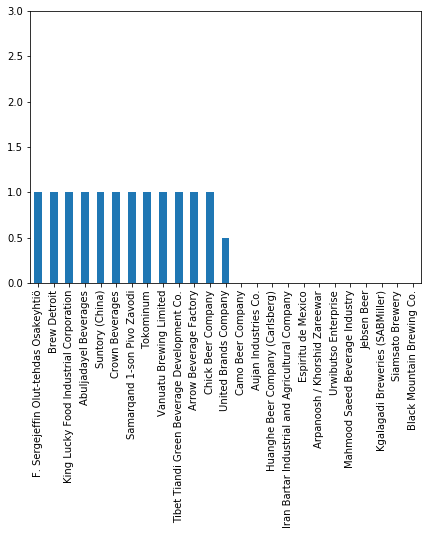

In [261]:
# Get the n most lowly rated breweries
# ------------------------------------------------------------------------------

# Prints table of n most lowly rated breweries with avg rating and beer count
print('-'*72)
print('|%-55s|%7s|%6s|' % ('Brewery', 'Rating', 'Count'))
print('-'*72)
for b, r, c in zip(brewerymeans[-n:].index, brewerymeans[-n:], brewerycounts[-n:]):
    print('|%-55s|%7.2f|%6d|' % (b, r, c))
print('-'*72)

# Plot a Pareto chart of n most highly rated breweries
ax = brewerymeans.iloc[-n:].plot.bar(figsize=(7,5))
ax.set_ylim(0, 3)

--------------------------------------------------
|Style                           | Rating|  Count|
--------------------------------------------------
|Ice Cider/Ice Perry             |  91.42|    133|
|Imperial Stout                  |  90.75|   4517|
|Imperial Porter                 |  88.63|    808|
|Saké - Koshu                    |  88.00|      4|
|Lambic Style - Gueuze           |  87.38|    132|
|Imperial IPA                    |  84.92|   3636|
|Sour/Wild Ale                   |  84.32|   3102|
|Lambic Style - Unblended        |  83.78|    104|
|Abt/Quadrupel                   |  83.76|    532|
|Barley Wine                     |  82.45|   2058|
|Sour Red/Brown                  |  81.97|    585|
|Black IPA                       |  81.45|   1472|
|American Strong Ale             |  80.57|   1418|
|Lambic Style - Fruit            |  78.58|    372|
|Baltic Porter                   |  78.47|    495|
|Foreign Stout                   |  76.69|    350|
|India Style Lager             

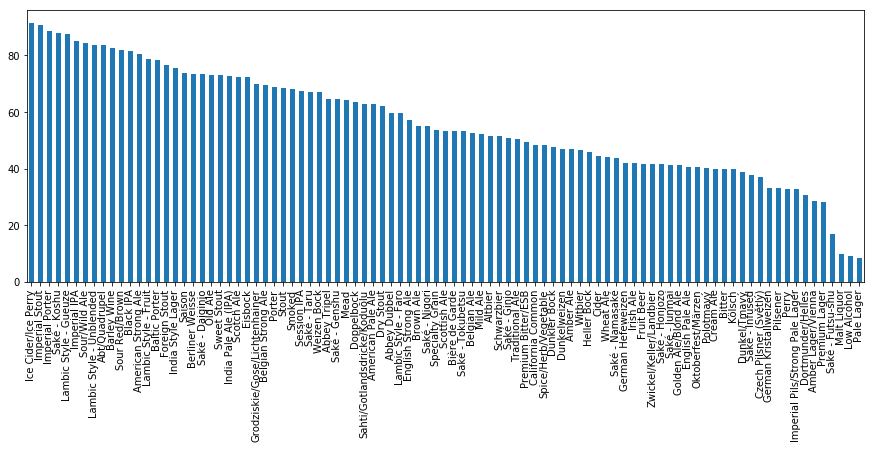

In [252]:
# Get the n most highly rated styles
# ------------------------------------------------------------------------------
n = 93  # All styles
byStyle = beerdf.groupby(by=['style'])
stylemeans = byStyle.rating.mean().sort_values(ascending=False)
stylecounts = [byStyle.get_group(style)['beer'].count()
                 for style in stylemeans[:n].index]
stylemeans.index = style_le.inverse_transform(stylemeans.index)  # Decode idx

# Prints table of n most highly rated breweries with avg rating and beer count
print('-'*50)
print('|%-32s|%7s|%7s|' % ('Style', 'Rating', 'Count'))
print('-'*50)
for s, r, c in zip(stylemeans[:n].index, stylemeans[:n], stylecounts):
    print('|%-32s|%7.2f|%7d|' % (s, r, c))
print('-'*50)

# Plot a Pareto chart of n most highly rated breweries
ax = stylemeans.iloc[:n].plot.bar(figsize=(15,5))
#ax.set_ylim(95, 102)

In [237]:
brewerymeans.head()

Wicked Barrel                    100.000000
Neill & Ross                     100.000000
Westvleteren Abdij St. Sixtus     99.500000
Brasserie Rochefort               99.333333
Schramm’s Mead                    99.136364
Name: rating, dtype: float64

## Predicting Beer Ratings

Let's get a baseline for the cost function. We will try to predict a beer's rating using averages for:

1. The total
2. The specific brewery
3. The specific style

Notice that we're using averages obtained from training set as prediction for training and test sets since it makes no since to predict test values using the values themselves.

In [74]:
# Baseline predictions
# ------------------------------------------------------------------------------

# Ground truth
y = beer_train['rating']
y_test = beer_test['rating']

# Prediction based on total (training) avg
yhat = y.mean()
print('Cost applied to train (prediction based on total avg): %10.3f' %
      cost(y, yhat))
print('Cost applied to test (prediction based on total avg): %11.3f' %
      cost(y_test, yhat))

# Prediction based on style avg
style_means = beer_train.groupby(by=['style']).rating.mean()
yhat = beer_train['style'].map(lambda x: style_means[x])
print('Cost applied to train (prediction based on style avg): %10.3f' %
      cost(y, yhat))
yhat_test = beer_test['style'].map(lambda x: style_means[x])
print('Cost applied to test (prediction based on style avg): %11.3f' %
      cost(y_test, yhat_test))

# Prediction based on brewery avg
brewery_means = beer_train.groupby(by=['brewery'])['rating'].mean()
yhat = beer_train['brewery'].map(lambda x: brewery_means[x])
print('Cost applied to train (prediction based on brewery avg): %8.3f' %
      cost(y, yhat))
# Note if brewery has no mean, using total avg=y.mean()
train_mean = y.mean()
yhat_test = beer_test['brewery'].map(lambda x: brewery_means[x] 
                                if x in brewery_means else train_mean)
print('Cost applied to test (prediction based on brewery avg): %9.3f' %
      cost(y_test, yhat_test))

Cost applied to train (prediction based on total avg):    819.561
Cost applied to test (prediction based on total avg):     818.204
Cost applied to train (prediction based on style avg):    409.384
Cost applied to test (prediction based on style avg):     410.048
Cost applied to train (prediction based on brewery avg):  270.376
Cost applied to test (prediction based on brewery avg):   369.895


Looks like brewery average is the best predictor for a beers rating. This makes sense. Brewery fan loyalty is pretty big in craft beer. However, it doesn't generalize well to other data.

Let's see if we can do better with a simple decision tree model.

Cost applied to train (using DecisionTreeRegressor):     35.407
Cost applied to val (using DecisionTreeRegressor):      329.536
Cost applied to test (using DecisionTreeRegressor):     336.700

Percentage of absolute errors that are less than 10: 51.43%

Absolute Errors description:

count    22444.000000
mean        13.227649
std         12.717567
min          0.000000
25%          3.500000
50%          9.000000
75%         19.000000
max         92.000000
Name: rating, dtype: float64


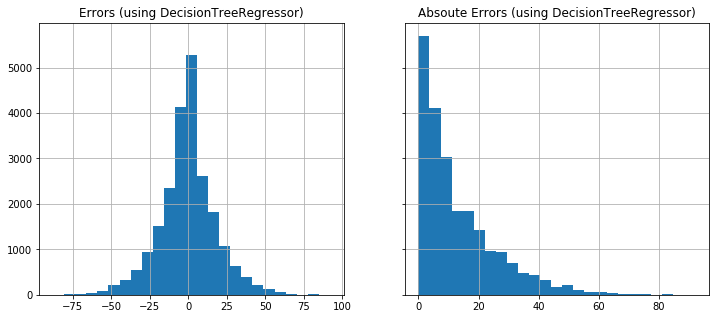

In [269]:
# Decision tree model
# ------------------------------------------------------------------------------

model = tree.DecisionTreeRegressor()
X = beer_train.iloc[:, 1:-1]  # Cuts out: beer, rating
y = beer_train.iloc[:, -1]    # Cuts out: everything but rating
model.fit(X, y)
yhat = model.predict(X)
print('Cost applied to train (using DecisionTreeRegressor): %10.3f' %
      cost(y, yhat))

X_val = beer_valid.iloc[:, 1:-1]
y_val = beer_valid.iloc[:, -1]
yhat_val = model.predict(X_val)
print('Cost applied to val (using DecisionTreeRegressor): %12.3f' %
      cost(y_val, yhat_val))

X_test = beer_test.iloc[:, 1:-1]
y_test = beer_test.iloc[:, -1]
yhat_test = model.predict(X_test)
evaluate(y_test, yhat_test, 'DecisionTreeRegressor')

Hey, that's a little better! Let's see if we can do even better.

Let's try some ensemble methods. We will first try some Random Forest models.

In [270]:
# Random Forest model
# ------------------------------------------------------------------------------

model = RandomForestRegressor(n_estimators=600, criterion='mse', 
                              max_features='sqrt', n_jobs=-1, max_depth=39, 
                              min_samples_split=22, min_samples_leaf=1, 
                              min_impurity_split=1e-8)
model.fit(X, y)
yhat = model.predict(X)
print('Cost applied to train (using RandomForestRegressor): %10.3f' %
      cost(y, yhat))
print('Average error on train prediction: %f' %
      cost(y, yhat, criteria='mae'))
yhat_val = model.predict(X_val)
print('Cost applied to val (using RandomForestRegressor): %11.3f' %
      cost(y_val, yhat_val))
print('Average error on val prediction: %f' %
      cost(y_val, yhat_val, criteria='mae'))

Cost applied to train (using RandomForestRegressor):    132.322
Average error on train prediction: 8.639476
Cost applied to val (using RandomForestRegressor):     185.620
Average error on val prediction: 10.249524


Cost applied to test (using RandomForestRegressor):     189.835

Percentage of absolute errors that are less than 10: 59.52%

Absolute Errors description:

count    22444.000000
mean        10.363883
std          9.079038
min          0.001102
25%          3.504925
50%          7.894041
75%         14.753448
max         78.385692
Name: rating, dtype: float64


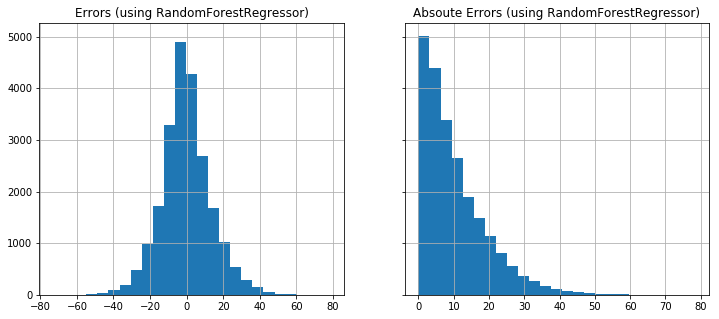

In [271]:
# Evaluate Random Forest on test data
# ------------------------------------------------------------------------------
yhat_test = model.predict(X_test)
evaluate(y_test, yhat_test, 'RandomForestRegressor')

In [272]:
# Ada Boost model
# ------------------------------------------------------------------------------

model = AdaBoostRegressor()
model.fit(X, y)
yhat = model.predict(X)
print('Cost applied to train (using RandomForestRegressor): %10.3f' %
      cost(y, yhat))
print('Average error on train prediction: %f' %
      cost(y, yhat, criteria='mae'))
yhat_val = model.predict(X_val)
print('Cost applied to val (using RandomForestRegressor): %11.3f' %
      cost(y_val, yhat_val))
print('Average error on val prediction: %f' %
      cost(y_val, yhat_val, criteria='mae'))

Cost applied to train (using RandomForestRegressor):    301.905
Average error on train prediction: 14.527677
Cost applied to val (using RandomForestRegressor):     302.576
Average error on val prediction: 14.538581


Cost applied to test (using AdaBoostRegressor):     302.746

Percentage of absolute errors that are less than 10: 37.29%

Absolute Errors description:

count    22444.000000
mean        14.579704
std          9.496440
min          0.004800
25%          6.905274
50%         13.313635
75%         21.255467
max         64.890547
Name: rating, dtype: float64


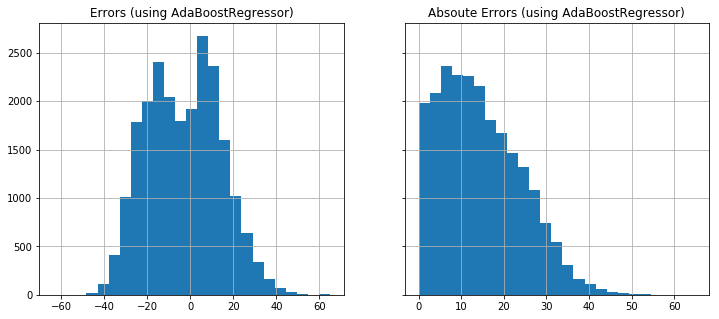

In [273]:
# Evaluate Random Forest on test data
# ------------------------------------------------------------------------------
yhat_test = model.predict(X_test)
evaluate(y_test, yhat_test, 'AdaBoostRegressor')